In [1]:
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os

In [54]:
# Load the data
np.random.seed(5)
def read_graph(filepath):
    # Use the largest connected component from the graph
    graph = nx.read_edgelist(filepath, nodetype=int).to_undirected()
    graph = max(nx.connected_component_subgraphs(graph), key=len)
    
    # Split the graph edges into train and test
    random_edges = list(graph.edges())
    np.random.shuffle(random_edges)
    train_edges = random_edges[:graph.number_of_edges()//2]
    test_edges = random_edges[graph.number_of_edges()//2:]
    
    # Create the training graph
    train_graph = nx.Graph()
    train_graph.add_edges_from(train_edges)
    train_graph = max(nx.connected_component_subgraphs(train_graph), key=len)
    
    # Create the test graph
    test_graph = nx.Graph()
    test_graph.add_edges_from(test_edges) 
    
    return train_graph, test_graph
    
# graph, graph_test = read_graph("./dataset/email-Eu-core.txt")
# graph, graph_test = read_graph("./dataset/0.edges")
graph, graph_test = read_graph("./dataset/1912.edges")
# graph, graph_test = read_graph("./dataset/gnutella08.txt")

In [55]:
# Compare the eigenvectors of the markov matrix of the vanilla and regularised graphs
def get_eigen(A):
    DS = np.diag(1. / np.sqrt(np.ravel((np.sum(A, 1)))))
    L = np.identity(np.shape(A)[0]) - np.matmul(np.matmul(DS, A), DS)
    val, vec = LA.eigh(L)
    return 1 - val, np.matmul(DS, vec)

sorted_nodes = list(graph.nodes())
sorted_nodes.sort()
S = nx.to_numpy_matrix(graph, nodelist=sorted_nodes)

# Tao is initialised with the average degree of the graph
N = graph.number_of_nodes()
tao = np.mean(np.ravel(np.sum(S, 1))) 
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

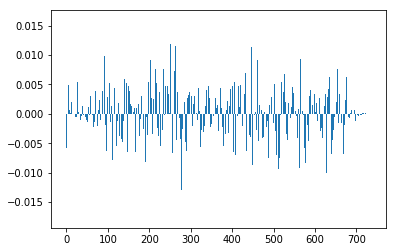

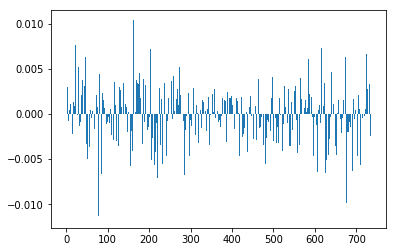

In [58]:
# Compare the eigenvectors of the laplacian of the two graphs
def plot_array(eigenval):
    plt.bar(np.arange(len(eigenval)), eigenval)
    plt.show()
    
plot_array(np.ravel(vec_van[2, :]))
plot_array(np.ravel(vec_reg[2, :]))
# plot_array(np.ravel(vec_van[:, 4]), np.ravel(vec_reg[:, 4]))

In [50]:
# Compute the number of nodes in the smallest partition set.
sc_van = SpectralClustering(2, affinity='precomputed', n_init=1000).fit(S)
sc_reg = SpectralClustering(2, affinity='precomputed', n_init=1000).fit(SR)

def min_binary_part_label(labels):
    return int(np.sum(labels) <= len(labels) - np.sum(labels))

In [51]:
# Compute the size of the smallest partition
van_min_part_size = min(np.sum(sc_van.labels_), N - np.sum(sc_van.labels_))
reg_min_part_size = min(np.sum(sc_reg.labels_), N - np.sum(sc_reg.labels_))
print(van_min_part_size)
print(reg_min_part_size)

56
65


In [52]:
# Compute the conductange of the smallest set
from networkx.algorithms.cuts import conductance

sorted_nodes = np.array(sorted_nodes)
van_min_part_label = min_binary_part_label(sc_van.labels_)
van_nodes_with_label = sorted_nodes[sc_van.labels_ == van_min_part_label]
reg_min_part_label = min_binary_part_label(sc_reg.labels_)
reg_nodes_with_label = sorted_nodes[sc_reg.labels_ == reg_min_part_label]

print("Vanilla conductance on train: {}".format(conductance(graph, van_nodes_with_label)))
print("CoreCut conductance on train: {}".format(conductance(graph, reg_nodes_with_label)))
print("Vanilla conductance on test: {}".format(conductance(graph_test, van_nodes_with_label)))
print("CoreCut conductance on test: {}".format(conductance(graph_test, reg_nodes_with_label)))

Vanilla conductance on train: 0.3760262725779967
CoreCut conductance on train: 0.2772532188841202
Vanilla conductance on test: 0.3879239040529363
CoreCut conductance on test: 0.2791461412151067


In [53]:
# Bechmark the execution time for the computation of eigenvalues for the two matrices
def benchmark(fct):   
    start = time.time()
    fct()
    end = time.time()
    return end-start

van_times, reg_times = [], []
runs = 10

for run in range(runs):
    van_times.append(benchmark(lambda: get_eigen(S)))
    reg_times.append(benchmark(lambda: get_eigen(SR)))

print("{}+-{}".format(np.mean(van_times), np.std(van_times)))
print("{}+-{}".format(np.mean(reg_times), np.std(reg_times)))

0.010360789299011231+-0.005325378685420514
0.00927751064300537+-0.0029197706406539157
